# Groundwater influence on fluxes



## Ensemble years 


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, date
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from scipy.misc import imread
import matplotlib.cbook as cbook

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [18]:
def ensemble_year(vals, time):

    
    
    ens = np.zeros([366])
    ens7d = np.zeros([367])
    
    
    DOY = time.dayofyear[0:len(vals)] 

    for iday in range(0,366):
        ens[iday] = np.mean( vals[DOY == (iday+1)]  ) 
        
    #7-day running mean
    N = 7
    for iday in range(0,367):
        if iday > (366-N):
            ens7d[iday]  = np.mean( np.concatenate( (ens[iday:366], ens[0:(N-(366-iday))] )) )

        else:    
            ens7d[iday] = np.mean(ens[iday:(iday+N)])
            
    return ens7d
    
    #DOY = tobs.dayofyear
    #eo_ens = np.zeros([366])
    
    #calculate ensemble for fluxtowers
    #for iday in range(0,366):
    #    eo_ens[iday] = np.mean( ea_tmp[DOY == (iday+1)]  )  #mm/d


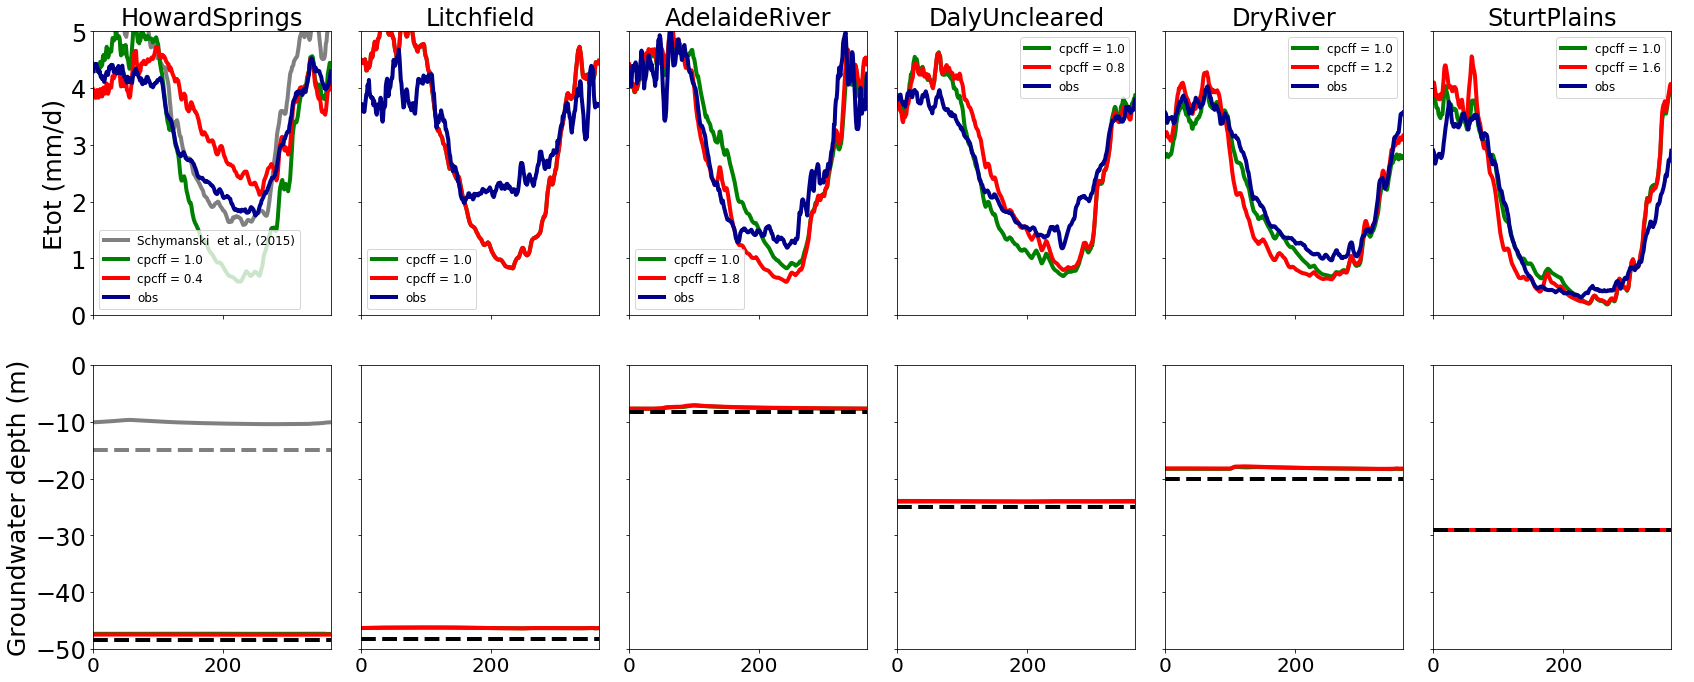

In [42]:
#ensemble year

i_site = 0
basin = ["HowardSprings", "Litchfield", "AdelaideRiver",  "DalyUncleared", "DryRiver",  "SturtPlains"]
basin_short = ["howard","litch","adelaide", "daly",  "dry",  "sturt"]


cpcff_vals = np.arange(0.2,2.8, 0.2)
cpcff_str = map(str, np.round(cpcff_vals,1) ) 
cpcff_str = list(cpcff_str)

cpcff_best = ['0.4', '1.0', '1.8', '0.8', '1.2', '1.6' ]


i_cz = [ 48.40, 48.20, 8.20, 25.0, 20.0, 29.0  ]


plt.rcParams['xtick.labelsize'] = 20
fig, ax   = plt.subplots(nrows=2, ncols=6, figsize=(24, 10), sharex=True, sharey='row') 

icol = 0
irow = 0

for ibasin in  np.arange(0,6):  
    
    #load fluxtower observations
    ea_tmp = np.loadtxt("../../data/DINGO/Ea_"+ basin_short[ibasin] +".txt", usecols=2) #mm/d
    tobs =  np.genfromtxt("../../data/DINGO/Ea_"+ basin_short[ibasin] +".txt",usecols=0, dtype=np.str )#mm/d
    tobs= pd.date_range(tobs[0], tobs[-1], freq='D')
         
    eo7d = ensemble_year(ea_tmp, tobs)

    try:
        #load data free-draining conditions
        inputfile = "../../data/VOM_output/"+ basin[ibasin] + "/freedrainage_cpcff1.0/sce_best/results_daily.txt"  
        data1 = np.genfromtxt(inputfile, names=True)

        #load data best cpcff
        inputfile = "../../data/VOM_output/" + basin[ibasin] + "/freedrainage_cpcff" + cpcff_best[ibasin] + "/sce_best/results_daily.txt"
        data2 = np.genfromtxt(inputfile, names=True)
        
        #calculate total evaporation
        e1 = data1["esoil"] + data1["etmt"] + data1["etmg"]
        e2 = data2["esoil"] + data2["etmt"] + data2["etmg"]

        #groundwater tables
        gw1 = data1["zw"] 
        gw2 = data2["zw"] 
        
        #define timeseries
        tmod1 = pd.date_range( data1["fyear"][0] + data1["fmonth"][0]  + data1["fday"][0], freq = "D", periods = len(e1))
        tmod2 = pd.date_range( data2["fyear"][0] + data2["fmonth"][0]  + data1["fday"][0], freq = "D", periods = len(e2))
            
        #use last 10 years for ensembles
        tmp1 = e1[-3650:]
        tmp2 = e2[-3650:]

        tmp3 = gw1[-3650:]
        tmp4 = gw2[-3650:]
        
        
        e7d1 = ensemble_year(tmp1, tmod1[-3650:])*1000
        e7d2 = ensemble_year(tmp2, tmod2[-3650:])*1000
        eo7d2 = ensemble_year(tmp2, tmod2[-3650:])*1000
        
        gw7d1 = ensemble_year(tmp3, tmod1[-3650:])
        gw7d2 = ensemble_year(tmp4, tmod2[-3650:])
        
        if(basin[ibasin] == "HowardSprings"):
            inputfile = "../../data/VOM_output/additional_analyses/comp2015/0_benchmark/resultsdaily.txt"
            data2015 = np.genfromtxt(inputfile, names=True)
        
            tmod = pd.date_range( data2015["year"][0] + data2015["month"][0]  + data2015["day"][0], freq = "D", periods = len(data2015["day"]))
            e2015 = data2015["esoil"] + data2015["etm_t"] + data2015["etm_g"]
            gw2015 = data2015["ws"] 
            
            e7d2015 = ensemble_year(e2015[-3650:], tmod[-3650:])*1000
            ax[0, ibasin].plot(range(0,367), e7d2015, color="gray", linewidth=4, label = "Schymanski  et al., (2015)")

            gw7d2015 = ensemble_year(gw2015[-3650:], tmod[-3650:])
            ax[1, ibasin].plot(range(0,367), -(15-gw7d2015), color="gray", linewidth=4,  label = "Schymanski  et al., (2015)")
            ax[1, ibasin].plot([0,367], [-15,-15], "--", color="gray", linewidth=4)   

        

        ax[0, ibasin].plot(range(0,367), e7d1, color = "green", linewidth=4, label = "cpcff = 1.0")
        ax[0, ibasin].plot(range(0,367), e7d2, color="red", linewidth=4, label="cpcff = " + cpcff_best[ibasin])        
        
        ax[0, ibasin].plot(range(0,367), eo7d, color="darkblue", linewidth=4, label = "obs")
        
        ax[1, ibasin].plot(range(0,367), -(i_cz[ibasin]-gw7d1), color = "green", linewidth=4, label = "cpcff = 1.0")
        ax[1, ibasin].plot(range(0,367), -(i_cz[ibasin]-gw7d2), color="red", linewidth=4, label="cpcff = " + cpcff_best[ibasin])   
        
        ax[1, ibasin].plot([0,367], [-i_cz[ibasin],-i_cz[ibasin]], "--", color="black", linewidth=4, label="bedrock")   

        for tick in ax[0, ibasin].yaxis.get_major_ticks():
            tick.label.set_fontsize(24)
        for tick in ax[1, ibasin].yaxis.get_major_ticks():
            tick.label.set_fontsize(24)
            
    except OSError:
        print("not found")
            
    #ax0.set(ylabel = r'Residuals Et ( $\sigma_{ET} $  )', xlabel = '' )
    #ax0.set_xlim([datetime(year[ibasin],1, 1), datetime( year[ibasin] ,12, 31)])  
    ax[1, ibasin].set_ylim([  -50, 0 ])
    ax[0, ibasin].set_ylim([  0, 5 ])

    ax[0, ibasin].set_xlim([ 0, 366 ])  


    ax[0, ibasin].set_title(basin[ibasin], fontsize = 24)
        
        #ax[irow, icol].set_xlabel('DOY' , size=18   )
    


    ax[0, ibasin].legend(prop={'size':12})
    #if(icol == 0):
    #    ax[irow, icol].set_ylabel( r'cpcff = ' + cpcff  +' ($\mu$$mol$ $m^3$ $s^{-1}$)', fontsize=18)
   

        

    
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax[0,0].set_ylabel("Etot (mm/d)", size = 25)
ax[1,0].set_ylabel("Groundwater depth (m)", size = 25)

plt.tight_layout()
plt.show()

